In [1]:
import numpy as np
import matplotlib.pyplot as plt

# PyTorch only for MNIST dataset loading
import torch
import torchvision
import torchvision.transforms as transforms

Initial energy = -1312.1510863484805
Initial Mattis overlaps:
 [[0.77295918 0.84438776 0.86989796]
 [0.77295918 0.84438776 0.86989796]
 [0.77295918 0.84438776 0.86989796]]

Final energy = -1857.964131335582
Final Mattis overlaps:
 [[0.61734694 1.         0.71428571]
 [1.         0.61734694 0.64285714]
 [0.68112245 0.75255102 0.96173469]]


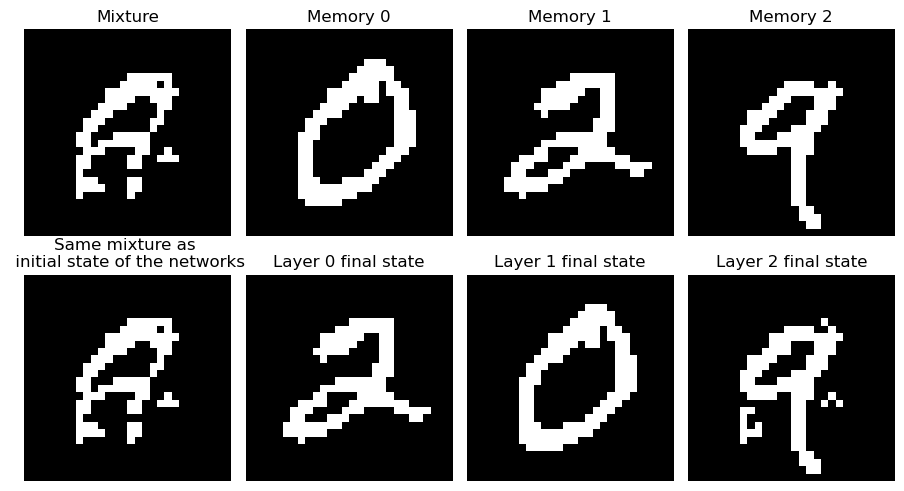

In [139]:
class LHopfield:
    """
    Implements the 'quadratic' multi-layer Hopfield model from Eq. (4.1) of
    'Networks of neural networks: more is different.'
    
    Hamiltonian:
      H̃(σ) = -N * sum_{a,mu} (m_a^mu)^2
              - H * sum_{a,i} sigma^a_i * h_i
              + N * lambda * sum_{a != b} [ sum_{mu} (m_a^mu * m_b^mu) ]^2

    See the paper for details. The difference from the standard Hopfield is that
    inter-layer terms use the square of the *sum* of overlaps, i.e. [sum_{mu}(m_a^mu m_b^mu)]^2.

    Parameters
    ----------
    L : int
        Number of layers (networks).
    N : int
        Number of neurons (dimension of each pattern and each layer).
    lamb : float
        Inter-layer coupling strength lambda (>= 0).
    H : float
        External field strength (>= 0).
    custom_memories : np.ndarray or None, shape (N, L), optional   
        If not None, store these L patterns (digits) instead of random ±1.
        Each column is a flattened pattern of length N, with ±1 entries.
    """

    def __init__(self, L: int, N: int, lamb: float, H: float,
                 custom_memories=None):                           
        self.L = L
        self.N = N
        self.lamb = lamb
        self.H = H

        # (1) Decide how to get memories:
        if custom_memories is not None:                         
            # Use user-provided patterns
            # Expect shape = (N, L). Each column is one digit pattern in ±1.
            self.K = L
            self.memories = custom_memories
        else:
            # Keep the old random approach
            # For simplicity, use K = L distinct memories, each Nx1
            self.K = L
            self.memories = self._rademacher(N, self.K)  # shape (N, K)

        # (2) Build an input "mixture" from these L patterns
        mixture = np.sum(self.memories, axis=1)  # shape (N,)
        self.h = np.sign(mixture)                # shape (N,)

        # (3) Initialize states: each layer starts in that same spurious mixture
        self.states = np.stack([self.h.copy() for _ in range(self.L)], axis=0)  # shape (L,N)

    def _rademacher(self, dim, samples):
        return np.random.choice([-1, +1], size=(dim, samples))

    def _compute_mattis(self):
        """
        Compute and return the matrix of Mattis overlaps:
        m[a, mu] = (1/N)*sum_i [ states[a,i] * memories[i, mu] ].
        Result shape: (L, K)
        """

        m = np.empty((self.L, self.K), dtype=float)
        for a in range(self.L):
            # raw dot => length K
            raw_dots = self.states[a].dot(self.memories)
            # divide by N to get Mattis magnetizations
            m[a] = raw_dots / self.N
        return m

    def energy(self):
        """
        Returns the total energy H̃(σ) from Eq. (4.1), scaled by 1 (not 1/kT).
        """
        m = self._compute_mattis()  # shape (L,K)

        # 1) intra-layer: -N sum_{a,mu} (m_a^mu)^2
        intra = -self.N * np.sum(m*m)

        # 2) external field: - H sum_{a,i} sigma^a_i * h_i
        field_term = -self.H * np.sum(self.states * self.h)

        # 3) inter-layer: + N lambda sum_{a!=b} [ sum_{mu} m[a,mu]*m[b,mu] ]^2
        #    We'll sum over all pairs (a,b), a!=b. This double counts a,b and b,a.
        #    The original Eq. (4.1) uses sum_{a!=b}. Usually that is 2 * sum_{a<b}.
        #    We'll just do a!=b as the formula says.
        inter = 0.0
        # M[a,b] = sum_{mu} m[a,mu]*m[b,mu]
        # We'll precompute it to avoid repeated sums:
        M = np.matmul(m, m.T)  # shape (L,L), M[a,b] = sum_{mu} m[a,mu]*m[b,mu]
        # Now sum_{a!=b} M[a,b]^2:
        for a in range(self.L):
            for b in range(self.L):
                if a != b:
                    inter += (M[a,b]**2)
        inter *= self.lamb * self.N

        return intra + field_term + inter

    def update(self, epochs=10, noise_scale=0.2):
        """
        Synchronous update for 'epochs' sweeps.
        Local field h_tilde(a,i) = derivative (w.r.t. sigma^a_i) of -H̃(σ).
        Then states[a,i] <- sign[ h_tilde(a,i) + random_noise ].

        :param epochs: number of full-network update sweeps.
        :param noise_scale: standard deviation of small Gaussian noise added
                            to local field for exploration.
        """
        for _ in range(epochs):
            # 1) compute all Mattis overlaps m_a^mu
            m = self._compute_mattis()
            # 2) compute M[a,b] = sum_{mu} m[a,mu]*m[b,mu]
            M = np.matmul(m, m.T)

            # We'll build a new array for the updated states
            new_states = np.empty_like(self.states)

            # Precompute partial sums that appear frequently:
            # For the Hopfield-like part, derivative wrt sigma^a_i => +2 sum_{mu} [m[a,mu] * xi[i,mu]].
            # We'll store these as H_hop[a,i] = 2 sum_{mu} m[a,mu]*xi[i,mu].
            # Because m[a,mu] = (1/N)*sum_j sigma[a,j]*xi[j,mu], we do need to be mindful of the factor 2.
            # We'll do a loop or a matrix multiplication approach:

            # shape (L,K) x shape (N,K) => want shape (L,N). We'll do it carefully:
            #   sum_{mu} [ m[a,mu]* xi[i,mu ] ] for each a,i
            # We'll transpose memories => shape (K,N) so that m[a,mu] dot memories^T[mu,i]
            # but we want elementwise, so let's do a direct loop for clarity:
            H_hop = np.zeros((self.L, self.N), dtype=float)
            memories_T = self.memories.T  # shape (K,N)
            for a in range(self.L):
                for i in range(self.N):
                    # sum_{mu} [ m[a,mu] * xi[i,mu ] ]
                    # but xi[i,mu] is memories[i,mu], which is memories_T[mu,i]
                    val = 0.0
                    for mu in range(self.K):
                        val += m[a,mu] * memories_T[mu,i]
                    H_hop[a,i] = 2.0 * val

            # For the quadratic cross-term: partial wrt sigma^a_i => -2 lambda sum_{b!=a} [ M[a,b] * sum_{mu} m[b,mu]*xi^mu_i ].
            # We'll define cross[a,i] = sum_{b!=a} [ M[a,b] * sum_{mu} m[b,mu]* xi[i,mu ] ].
            # Then that piece of local field is  -2 * lambda * cross[a,i].
            cross_term = np.zeros((self.L, self.N), dtype=float)
            # We'll precompute cross_helper[b,i] = sum_{mu} [ m[b,mu]* xi[i,mu ] ]
            cross_helper = np.zeros((self.L, self.N), dtype=float)
            for b in range(self.L):
                for i in range(self.N):
                    val = 0.0
                    for mu in range(self.K):
                        val += m[b,mu]*memories_T[mu,i]
                    cross_helper[b,i] = val

            # now cross[a,i] = sum_{b!=a} [ M[a,b] * cross_helper[b,i] ]
            for a in range(self.L):
                for i in range(self.N):
                    val = 0.0
                    for b in range(self.L):
                        if b != a:
                            val += M[a,b] * cross_helper[b,i]
                    cross_term[a,i] = val

            # We'll do synchronous update
            noise = noise_scale * np.random.rand(self.L, self.N)
            for a in range(self.L):
                for i in range(self.N):
                    # local field = from intra-layer + field + from cross-layer
                    #   = H_hop[a,i] + H*h[i] - 2*lambda* cross_term[a,i]
                    h_tilde = H_hop[a,i] + self.H*self.h[i] - 2.0*self.lamb*cross_term[a,i]

                    # sign with small random additive noise
                    new_states[a,i] = np.sign(h_tilde + noise[a,i])

            self.states = new_states

    def overlaps(self):
        """
        Convenience function: returns the matrix of raw overlaps dot[a,mu]
        = sum_i sigma[a,i]*xi[i,mu], plus the normalized version 'm' (Mattis).
        """
        dot = np.empty((self.L,self.K), dtype=float)
        for a in range(self.L):
            dot[a] = self.states[a].dot(self.memories)
        m = dot / self.N
        return dot, m


def load_three_mnist_digits(digit_labels=(0,1,2), binarize_threshold=127):
    """
    Load the MNIST dataset, find the first example of each of the
    'digit_labels' in the training set, binarize its pixels to -1/+1,
    flatten it (28x28 -> length 784), and return shape (784, 3).
    """
    # 1) MNIST train set
    transform = transforms.ToTensor()  # each image => float32 [0..1]
    dataset = torchvision.datasets.MNIST(root=".", train=True, download=True, transform=transform)

    # 2) For each label in digit_labels, find the first example
    #    We'll store them in columns
    big_matrix = []
    for lbl in digit_labels:
        for img, lbl_actual in dataset:
            if lbl_actual == lbl:
                # convert from tensor shape (1,28,28) to numpy shape (28,28)
                arr = img.squeeze().numpy() * 255.0
                # Binarize => -1 or +1
                # threshold e.g. 127 => all pix>127 => +1, else -1
                binarized = np.where(arr> binarize_threshold, +1, -1)
                # Flatten from (28,28) => (784,)
                flat = binarized.flatten()
                big_matrix.append(flat)
                break

    # shape => (3, 784). We want (784,3) => transpose
    big_matrix = np.array(big_matrix)  # shape (3, 784)
    big_matrix = big_matrix.T          # shape (784, 3)
    return big_matrix



# 1) Load three digits from MNIST, e.g. 0, 1, 2.
digits_012 = load_three_mnist_digits(digit_labels=(0,2,9), binarize_threshold=127)
N, L = digits_012.shape  # N=784, L=3

# 2) Create our multi-layer Hopfield with these custom digits
net = LHopfield(L=L, N=N, lamb=0.2, H=0.2, custom_memories=digits_012)

print("Initial energy =", net.energy())
_, m_init = net.overlaps()
print("Initial Mattis overlaps:\n", m_init)

# 3) Show the mixture (self.h) and the 3 digits
fig, axes = plt.subplots(2, 4, figsize=(9,5))

# top row: the external mixture field + the 3 memory digits
axes[0,0].set_title("Mixture")
axes[0,0].imshow(net.h.reshape(28,28), cmap="gray", vmin=-1, vmax=1)
axes[0,0].axis("off")

for i in range(L):
    axes[0,i+1].set_title(f"Memory {i}")
    axes[0,i+1].imshow(net.memories[:,i].reshape(28,28), cmap="gray", vmin=-1, vmax=1)
    axes[0,i+1].axis("off")

# 4) Update the network
net.update(epochs=100, noise_scale=0.5)

print("\nFinal energy =", net.energy())
_, m_fin = net.overlaps()
print("Final Mattis overlaps:\n", m_fin)

# 5) Show the final states for each layer
axes[1,0].set_title("Same mixture as \n initial state of the networks")
axes[1,0].imshow(net.h.reshape(28,28), cmap="gray", vmin=-1, vmax=1)
axes[1,0].axis("off")

for i in range(L):
    axes[1,i+1].set_title(f"Layer {i} final state")
    axes[1,i+1].imshow(net.states[i].reshape(28,28), cmap="gray", vmin=-1, vmax=1)
    axes[1,i+1].axis("off")

plt.tight_layout()
plt.show()